# Uncertainty Quantification using Gaussian RBF and Bootstrapping
This workflow demonstrates estimating a 2D porosity map from sparse data points. It uses Gaussian Radial Basis Function(RBF) interpolation by incorporating data point bootstrapping to generate multiple possible map realizations.

This workflow utilizes a publicly available dataset provided by **Professor Michael J. Pyrcz** (GeostatsGuy)
> Pyrcz, M.J., 2024, GeoDataSets: Synthetic Subsurface Data Repository. Zenodo. doi:10.5281/zenodo.15169133
[https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_datasets.html](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_datasets.html)


**Workflow Overview**
1. Data Loading
2. Epsilon Optimization via Spatial Cross-Validation
3. Bootstrapping and Generating Realizations
4. E-Type and Uncertainty Calculation


Import necessary functions

In [75]:
from calc_UMG import calc_UMG

import numpy as np
import pandas as pd
from scipy.interpolate import RBFInterpolator
from scipy.stats import ks_2samp, gaussian_kde
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.stats import norm                            # Gaussian distribution assumed for local uncertainty


import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy.interpolate import Rbf                             # countours that extrapolate
from tqdm.notebook import tqdm
import pickle

def add_grid2():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def ecdf(arr):
    """Empirical CDF (x, F(x))"""
    x = np.sort(arr)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

GeostatsPy version: 0.0.74


### 1. Data Loading
Load Spatial Nonlinear Multivariate Sandstone Only Facies v5 Dataset


In [3]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v5_sand_only.csv")

df['Por'] = df['Por'] / 100.0                               # Convert to porosity fraction
xmin = 0.0; xmax = 10000.0; ymin = 0.0; ymax = 10000.0;

df['NPor'], por_mu, por_sigma = geostats.nscore(df, 'Por')  # Apply gaussian transformation

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)    # Split train / test

df = train_df.copy()    # To use exhaustive data comment out this line

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,189.0,2362.365079,1464.937657,27.000000,1142.000000,2330.000000,3689.000000,4955.000000
X,189.0,3347.089947,2613.427784,0.000000,1300.000000,2700.000000,4600.000000,9500.000000
Y,189.0,5797.301587,3410.194918,90.000000,2490.000000,6890.000000,8790.000000,9990.000000
Por,189.0,0.183486,0.041803,0.095110,0.150208,0.185539,0.216996,0.275949
Perm,189.0,493.916605,310.040976,0.000000,265.204423,450.370727,711.144066,1458.288193
AI,189.0,3947.358891,263.829317,3549.859605,3725.505997,3917.230964,4136.885363,4708.782401
Facies,189.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NPor,189.0,-0.008194,0.972293,-2.539185,-0.639924,-0.032499,0.662880,2.902353


### 2. Epsilon Optimization via Spatial Cross-Validation
Before we can generate our maps, we need to find the best setting for our Radial Basis Function (RBF) interpolator. The Gaussian RBF has a critical hyperparameter called epsilon (ϵ), which controls the "spread" or influence of each data point.

A **small epsilon** results in a broad, smooth interpolation where points far away have a significant influence.

A **large epsilon** results in a spiky, localized interpolation where only nearby points matter.

There's no single "correct" epsilon—the best value depends on the spatial structure of your data. To find it, we use K-Fold Cross-Validation. The process is:

Split Data: The dataset is divided into K "folds" (e.g., K=16).

Iterate: We run K iterations. In each iteration, one fold is held out as the test set, and the remaining K−1 folds are used as the training set.

Train and Test: An RBF model is trained on the training set for a specific epsilon, and its performance (e.g., Root Mean Squared Error - RMSE) is measured on the hold-out test set.

Average: The RMSE scores from all K iterations are averaged to get a robust performance measure for that epsilon.

We repeat this for a range of epsilon values and select the one that yields the lowest average RMSE. This ensures our model generalizes well to new, unseen data points.

In [4]:
x = df['X'].values
y = df['Y'].values
data_points = np.vstack([x,y]).T
v = df['NPor'].values

grid_min_x, grid_max_x = 0, 10000
grid_min_y, grid_max_y = 0, 10000

gx = np.linspace(grid_min_x, grid_max_x, 1000)
gy = np.linspace(grid_min_y, grid_max_y, 1000)

gxx, gyy = np.meshgrid(gx, gy)

grid_points = np.vstack([gxx.ravel(), gyy.ravel()]).T

In [58]:
k = 3

x_bins = np.linspace(grid_min_x, grid_max_x, k+1)
y_bins = np.linspace(grid_min_y, grid_max_y, k+1)

epsilon_candidates = np.logspace(-5,-1,200)
mean_errors = []

for eps in epsilon_candidates:

    fold_errors = []

    for i in range(k):
        for j in range(k):
            x_min, x_max = x_bins[j], x_bins[j+1]
            y_min, y_max = y_bins[i], y_bins[i+1]

            is_test = (
                (data_points[:, 0] >= x_min) & (data_points[:, 0] < x_max) &
                (data_points[:, 1] >= y_min) & (data_points[:, 1] < y_max)
            )

            if not np.any(is_test):
                continue    # Skip fold if no data inside

            is_train = ~is_test
            train_points = data_points[is_train]
            train_v = v[is_train]
            test_points = data_points[is_test]
            test_v = v[is_test]

            rbfi = RBFInterpolator(
                train_points,
                train_v,
                kernel='gaussian',
                epsilon=eps,
                smoothing=0.1
            )

            # Predict values for the test points
            predicted_v = rbfi(test_points)

            # Calculate Root Mean Squared Error (RMSE) for this fold
            rmse = np.sqrt(np.mean((predicted_v - test_v)**2))
            fold_errors.append(rmse)

    mean_error_for_eps = np.mean(fold_errors)
    mean_errors.append(mean_error_for_eps)

Optimal Epsilon: 0.000203
Minimum CV Error: 0.7443
Mean Baseline RMSE (predicting the average): 1.0179


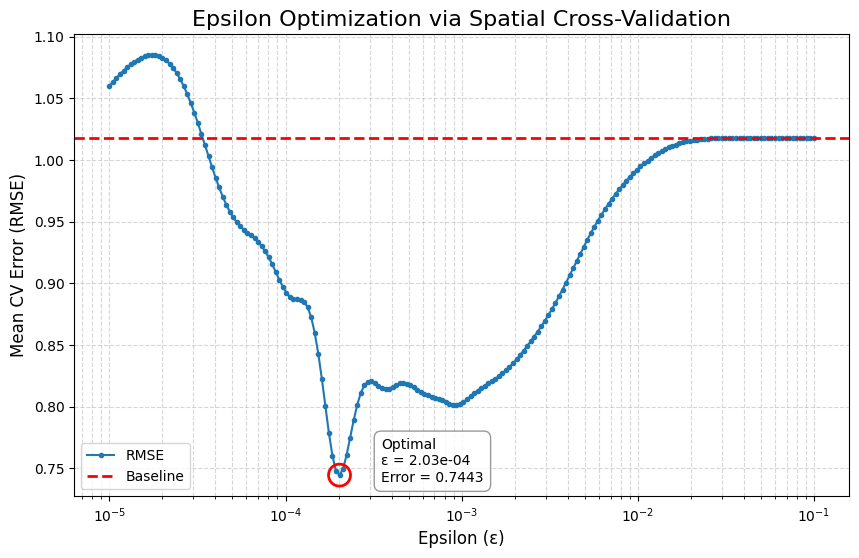

In [59]:
best_epsilon_index = np.argmin(mean_errors)
best_epsilon = epsilon_candidates[best_epsilon_index]
min_error = mean_errors[best_epsilon_index]

print(f"Optimal Epsilon: {best_epsilon:.6f}")
print(f"Minimum CV Error: {min_error:.4f}")


baseline_fold_errors = [] # List to store baseline error for each fold

for i in range(k):
    for j in range(k):
        x_min, x_max = x_bins[j], x_bins[j+1]
        y_min, y_max = y_bins[i], y_bins[i+1]
        is_test = (data_points[:, 0] >= x_min) & (data_points[:, 0] < x_max) & \
                  (data_points[:, 1] >= y_min) & (data_points[:, 1] < y_max)
        if not np.any(is_test): continue

        is_train = ~is_test
        train_points, train_v = data_points[is_train], v[is_train]
        test_points, test_v = data_points[is_test], v[is_test]

        mean_train_v = np.mean(train_v) # The prediction is just the mean of the training data
        baseline_rmse = np.sqrt(np.mean((mean_train_v - test_v)**2))
        baseline_fold_errors.append(baseline_rmse)

mean_baseline_rmse = np.mean(baseline_fold_errors)
print(f"Mean Baseline RMSE (predicting the average): {mean_baseline_rmse:.4f}")


plt.figure(figsize=(10, 6))

plt.plot(epsilon_candidates, mean_errors, marker='.', linestyle='-', label='RMSE')

plt.scatter(best_epsilon, min_error,
            s=250,                  # Size of the circle
            facecolors='none',      # Make the circle hollow
            edgecolors='red',       # Set the circle's border color to red
            linewidth=2,            # Set the border thickness
            zorder=5)               # Ensure the circle is drawn on top

annotation_text = f'Optimal\nε = {best_epsilon:.2e}\nError = {min_error:.4f}'
plt.annotate(
    text=annotation_text,
    xy=(best_epsilon, min_error),
    xytext=(30, 10),                 # Increased offset slightly for more space
    textcoords='offset points',
    ha='left',
    va='center',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.8)
)

plt.axhline(y=mean_baseline_rmse, color='red', linestyle='--', linewidth=2,
            label=f'Baseline')

plt.legend(loc='lower left')
plt.xscale('log')
plt.title('Epsilon Optimization via Spatial Cross-Validation', fontsize=16)
plt.xlabel('Epsilon (ε)', fontsize=12)
plt.ylabel('Mean CV Error (RMSE)', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Running CV for a single epsilon: 0.000203


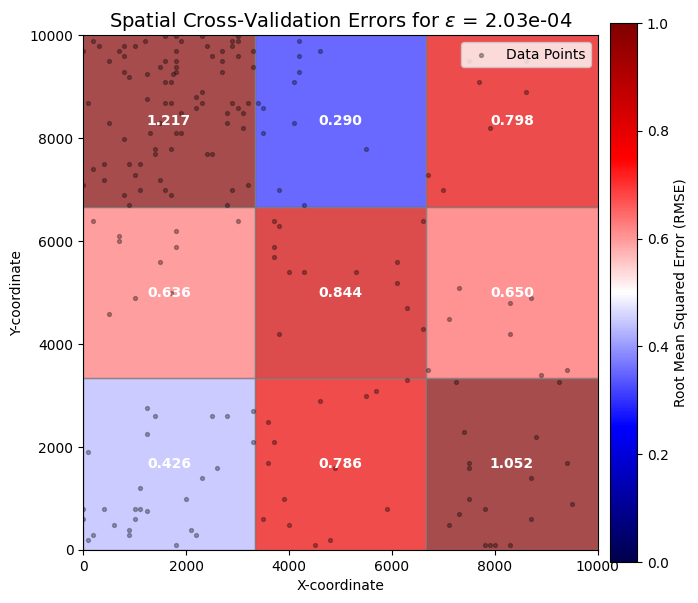

In [60]:
chosen_epsilon = 0.000203 # A reasonable epsilon for this kernel scale

def plot_cv_errors_on_map(fold_errors, x_bins, y_bins, epsilon, data_points=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 7))
    else:
        fig = ax.figure

    num_y_folds = len(y_bins) - 1
    num_x_folds = len(x_bins) - 1
    error_grid = np.array(fold_errors).reshape((num_y_folds, num_x_folds))

    min_error = error_grid.min()
    max_error = error_grid.max()
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('seismic') # A visually clear colormap

    for i in range(num_y_folds):
        for j in range(num_x_folds):
            x_min, x_max = x_bins[j], x_bins[j+1]
            y_min, y_max = y_bins[i], y_bins[i+1]
            width = x_max - x_min
            height = y_max - y_min

            error = error_grid[i, j]
            color = cmap(norm(error))

            rect = mpatches.Rectangle(
                (x_min, y_min), width, height,
                facecolor=color, alpha=0.7, edgecolor='gray'
            )
            ax.add_patch(rect)

            ax.text(
                x_min + width / 2, y_min + height / 2, f'{error:.3f}',
                ha='center', va='center', color='white', fontsize=10, weight='bold'
            )

    if data_points is not None:
        ax.scatter(
            data_points[:, 0], data_points[:, 1],
            c='black', s=8, alpha=0.3, label='Data Points'
        )
        ax.legend(loc='upper right')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Root Mean Squared Error (RMSE)')

    ax.set_title(f'Spatial Cross-Validation Errors for $\\epsilon$ = {epsilon:.2e}', fontsize=14)
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.autoscale_view()

    plt.show()


x_bins = np.linspace(grid_min_x, grid_max_x, k+1) # 4 folds
y_bins = np.linspace(grid_min_y, grid_max_y, k+1) # 4 folds

fold_errors_for_map = []
print(f"Running CV for a single epsilon: {chosen_epsilon}")

for i in range(k):
    for j in range(k):
        x_min, x_max = x_bins[j], x_bins[j+1]
        y_min, y_max = y_bins[i], y_bins[i+1]

        is_test = (
            (data_points[:, 0] >= x_min) & (data_points[:, 0] < x_max) &
            (data_points[:, 1] >= y_min) & (data_points[:, 1] < y_max)
        )

        # Ensure the test set is not empty
        if not np.any(is_test):
            fold_errors_for_map.append(np.nan) # Append NaN if no points in fold
            continue

        is_train = ~is_test
        train_points, train_v = data_points[is_train], v[is_train]
        test_points, test_v = data_points[is_test], v[is_test]

        rbfi = RBFInterpolator(
            train_points, train_v,
            kernel='gaussian', epsilon=chosen_epsilon, smoothing=0.1
        )
        predicted_v = rbfi(test_points)
        rmse = np.sqrt(np.mean((predicted_v - test_v)**2))
        fold_errors_for_map.append(rmse)

plot_cv_errors_on_map(
    fold_errors=fold_errors_for_map,
    x_bins=x_bins,
    y_bins=y_bins,
    epsilon=chosen_epsilon,
    data_points=data_points
)


While cross-validation gives us an optimal epsilon value, the number itself lacks a direct, intuitive meaning. To better understand the physical meaning of epsilon, we can calculate the physical distance over which this epsilon exerts a significant influence.
Let the **"effective radius of influence"** as the distance r at which the influence of a Gaussian RBF kernel drops to less than 5% of its maximum value at the center.
$$e^{-(\epsilon r)^2} = 0.01$$
Now, when we solve this equation for r:
$$r = \frac{\sqrt{\ln(100)}}{\epsilon} \approx \frac{2.146}{\epsilon}$$





In [61]:
eff_r = 1.731/chosen_epsilon
print("Effective radius of unfluence: ",eff_r)

Effective radius of unfluence:  8527.093596059114


#### Full Estimation

In [64]:
# eps = 0.000203
eps = chosen_epsilon
# eps = 0.000577

rbfi = RBFInterpolator(data_points, v, kernel='gaussian', epsilon=eps, smoothing=0.1)
z_map_flat = rbfi(grid_points)
z_map = z_map_flat.reshape(gxx.shape)
z_map = np.flipud(z_map)

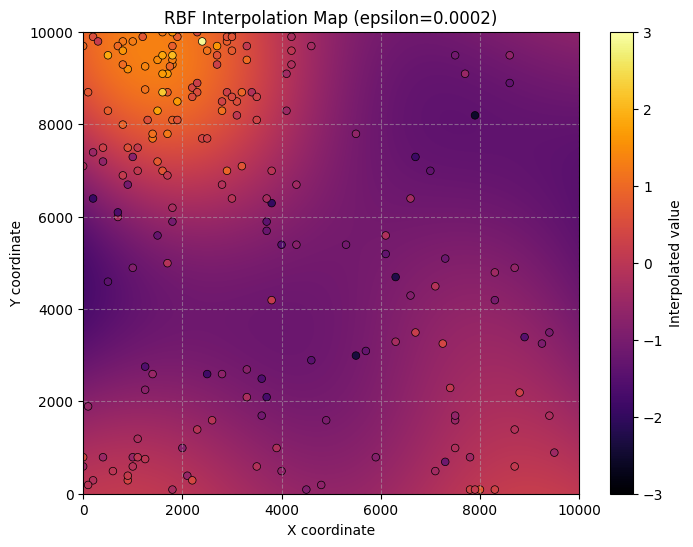

In [65]:
plt.figure(figsize=(8, 6))

vmin = -3
vmax = 3

img = plt.imshow(z_map, cmap='inferno',
                 extent=[grid_min_x, grid_max_x, grid_min_y, grid_max_y],
                 aspect='auto', vmin=vmin, vmax=vmax)

plt.scatter(x, y, c=v, s=30, cmap='inferno', edgecolors='black', linewidths=0.5, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(img)
cbar.set_label('Interpolated value')
plt.title('RBF Interpolation Map (epsilon={:.4f})'.format(eps))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 3. Bootstrapping and Generating Realizations

In [67]:
L = 100  # number of bootstrap realizations
z_map_concat = np.zeros((L, 1000, 1000))

for k in tqdm(range(L)):
    # print("Processing {}/{}".format(k, L))

    df_sample = df.sample(n=len(df), replace=True)
    df_unique = df_sample.drop_duplicates(subset=['X', 'Y'], keep='first').reset_index(drop=True)

    x = df_unique['X'].values
    y = df_unique['Y'].values
    data_points = np.vstack([x, y]).T
    v = df_unique['NPor'].values

    eps = chosen_epsilon
    rbfi = RBFInterpolator(data_points, v, kernel='gaussian', epsilon=eps, smoothing=0.1)
    z_map_flat = rbfi(grid_points)
    z_map = z_map_flat.reshape(gxx.shape)

    z_map_concat[k] = z_map


  0%|          | 0/100 [00:00<?, ?it/s]

Code for dumping/loading calculation results
Since the process can take a while

In [68]:
# Save
with open('RBF_realizations_1000.pkl', 'wb') as f:
    pickle.dump(z_map_concat, f)

In [ ]:
# Load
with open('RBF_realizations_1000.pkl','rb') as f:
    z_map_concat = pickle.load(f)

### 4. E-Type and Uncertainty Calculation

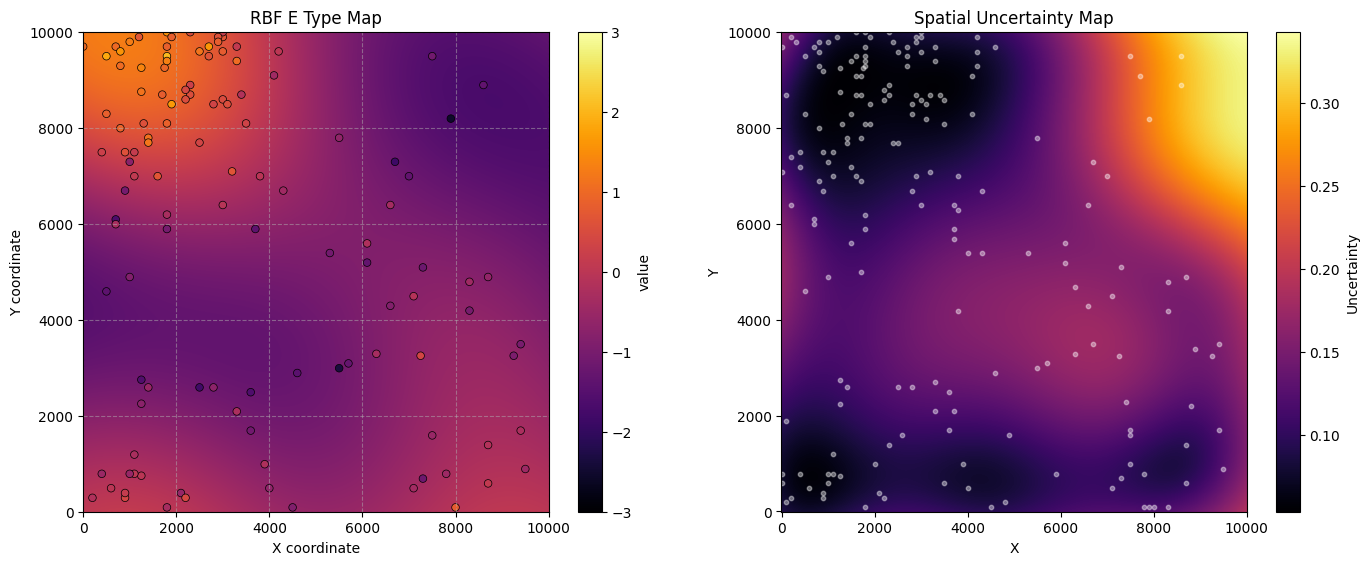

In [71]:
z_map = np.flipud(z_map)

uncertainty_map = np.std(z_map_concat, axis=0)
plt.subplot(121)
vmin = -3
vmax = 3

img = plt.imshow(z_map, cmap='inferno',
                 extent=[grid_min_x, grid_max_x, grid_min_y, grid_max_y],
                 aspect='auto', vmin=vmin, vmax=vmax)

plt.scatter(x, y, c=v, s=30, cmap='inferno', edgecolors='black', linewidths=0.5, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(img)
cbar.set_label('value')
plt.title('RBF E Type Map'.format(eps))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, linestyle='--', alpha=0.5)


plt.subplot(122)
im = plt.pcolormesh(gxx, gyy, uncertainty_map, cmap='inferno')
plt.scatter(df['X'],df['Y'], marker='o', alpha=0.4, s=10, color='white')
cbar = plt.colorbar(im)
cbar.set_label('Uncertainty')

plt.title("Spatial Uncertainty Map")
plt.xlabel('X')
plt.ylabel('Y')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()
plt.show()

##### Model Check

In [73]:
x_idx = ((test_df['X'] - 5) // 10).astype(int)
y_idx = ((test_df['Y'] - 5) // 10).astype(int)

x_idx = np.clip(x_idx, 0, 1000-1)
y_idx = np.clip(y_idx, 0, 1000-1)

test_est = z_map[y_idx, x_idx]
test_var = uncertainty_map[y_idx, x_idx]
test_std = np.sqrt(test_var)


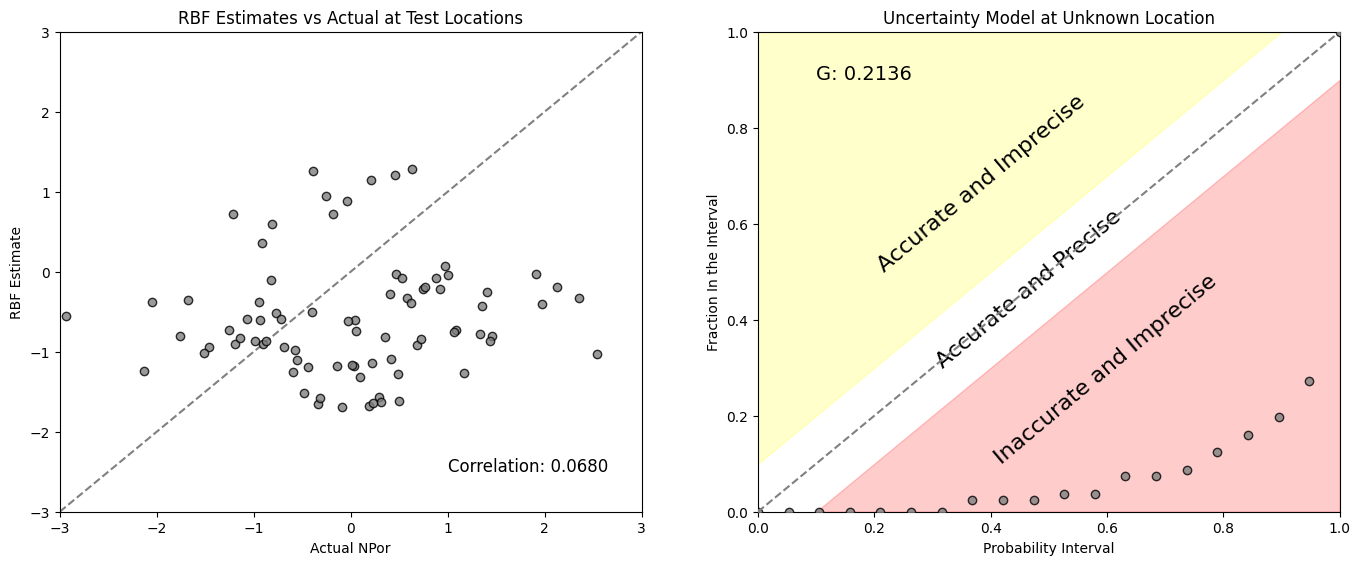

In [79]:
plt.subplot(121)
plt.scatter(test_df['NPor'],test_est,c='grey',edgecolor='black',marker='o',alpha=0.8,zorder=100)
plt.plot([-3,3],[-3,3],c='grey',ls='--')
plt.xlim([-3,3]); plt.ylim([-3,3])
plt.title('RBF Estimates vs Actual at Test Locations')
plt.xlabel('Actual NPor'); plt.ylabel('RBF Estimate')
correlation = np.corrcoef(test_df['NPor'], test_est)[0, 1]
plt.annotate(f"Correlation: {correlation:.4f}", xy=[1., -2.5], fontsize=12)

percentiles = norm.cdf(test_df['Por'].values, test_est, test_std)
test_df['Percentile'] = percentiles

bins = 20

fraction_in = np.zeros(bins)  # calculate and plot the accuracy plot
p_intervals = np.linspace(0.0, 1.0, bins)
for i, p in enumerate(p_intervals):
    test_result = (test_df['Percentile'] > 0.5 - 0.5 * p) & (test_df['Percentile'] < 0.5 + 0.5 * p)
    fraction_in[i] = test_result.sum() / len(test_df)

plt.subplot(122)
plt.scatter(p_intervals, fraction_in, c='grey', edgecolor='black', marker='o', alpha=0.8, zorder=100)
plt.plot([0.0, 1.0], [0.0, 1.0], c='grey', zorder=100, ls='--')
plt.fill_between([0.1, 1], [0, 0.9], [0, 0], color='red', alpha=0.2, zorder=1)
plt.fill_between([0, 0.9], [0.1, 1.0], [1.0, 1.0], color='yellow', alpha=0.2, zorder=1)
plt.xlim([0.0, 1.0]);
plt.ylim([0, 1.0])
plt.annotate('Accurate and Precise', xy=[0.3, 0.3], rotation=40, fontsize=16)
plt.annotate('Inaccurate and Imprecise', xy=[0.4, 0.1], rotation=40, fontsize=16)
plt.annotate('Accurate and Imprecise', xy=[0.2, 0.5], rotation=40, fontsize=16)

plt.annotate(f'G: {calc_UMG(p_intervals, fraction_in):.4f}', xy=[0.1, 0.9], fontsize=14)

plt.title('Uncertainty Model at Unknown Location')
plt.xlabel('Probability Interval');
plt.ylabel('Fraction In the Interval')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()
